In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import keras
import pandas as pd
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  
import helpers

# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')

PATH = "{}/{}".format(DATASET, "isic2016numpy")
# load data
x_train = np.load("{}/x_train.npy".format(PATH))
y_train = np.load("{}/y_train.npy".format(PATH))
x_train.shape, y_train.shape

MODEL_PATH = os.path.join(ROOT_DIR, "models")
print(ROOT_DIR)
print(os.listdir(MODEL_PATH))

Using TensorFlow backend.
/home/hasib/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasib/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasib/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasib/anaconda3/envs/env/l

/home/hasib/lesion-learnt
['b2m_510.h5', 'b2m_715.h5', 'generator_100.h5', 'generator_isic2016_b2m_100.h5', 'b2m_597.h5', 'b2m_784.h5', '4_gan_100.h5', 'b2m_571.h5']


In [2]:
#b2m_510 done
#b2m_597 done
#b2m_784 done

model_name = 'b2m_510.h5'
model = load_model(os.path.join(MODEL_PATH, model_name), custom_objects={'InstanceNormalization':InstanceNormalization})
#model.summary()

/home/hasib/anaconda3/envs/env/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def predict(model, img):
    
    if img.shape[0] != 256:
        print("Resizing image..")
        img = cv2.resize(img, (256, 256))
    
    # Normalize image as the trained distribution
    
    img = img/127.5 - 1.
    
    # Normalize imgae [0, 1]
    #img = img.astype('float32')
    #img /= 255.
    
    img = np.expand_dims(img, axis=0)
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    
    
    # Rescale to [0,1]
    #img = 0.5 * img + 0.5
    img = (img - np.min(img))/np.ptp(img)
    
    return img


def oversample(x, y, model):
    '''
    Some cool stuff
    INPUT
        x: 
        y:
        model:
        
    OUTPUT
        New folder in the current directory.
    '''
    
    print("Before oversampling :", x.shape, y.shape)
    
    
    # majority class
    majority_samples = []
    for img, label in zip(x, y):
        if label[1] == 0:
            majority_samples.append(img)
        else:
            pass
    
    # numpy array of majority classes
    majority_samples = np.array(majority_samples)
    
    # minority generated samples
    synthetic_samples = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples):
        
        # translate to malignant
        pred = predict(model, img)
        synthetic_samples.append(pred)
    
    # make labels for generated minority classes
    y_syn = np.array([1 for _ in range(len(synthetic_samples))])
    y_syn = np_utils.to_categorical(y_syn, 2)
    
    # Scale training set to [0, 1]
    x = x.astype('float32')
    x /= 255
    
    # merge and shuffle training and generated samples
    x_balanced = np.concatenate( (x, synthetic_samples), axis = 0)
    y_balanced = np.concatenate( (y, y_syn), axis = 0)
    x_balanced, y_balanced = helpers.shuffle_dataset(x_balanced, y_balanced)
    
    assert len(majority_samples) == len(synthetic_samples), "This should be same! If not, check model code"
    assert len(x_balanced) == len(synthetic_samples) + len(x_train), "Check oversampler code"
    print("After oversampling: ", x_balanced.shape, y_balanced.shape)
    
    return majority_samples, synthetic_samples, x_balanced, y_balanced


In [4]:
raw, gen, x_new, y_new = oversample(x_train, y_train, model)

  0%|          | 0/727 [00:00<?, ?it/s]

Before oversampling : (900, 256, 256, 3) (900, 2)



100%|██████████| 727/727 [00:52<00:00, 13.74it/s]


Shuffling data
After oversampling:  (1627, 256, 256, 3) (1627, 2)


### Divide the synthetic malignant from raw dataset for visualization

In [5]:
gen = np.array(gen)
print(gen.shape)

# make new label for plotting
gen_label = np.array([2 for _ in range(len(gen))])
gen_label = np_utils.to_categorical(gen_label, 3)
print(gen_label.shape)

# change original label to 3 onehot encoded vector
y_3 = np.array([np.argmax(x) for x in y_train])
print(y_3.shape)
y_3 = np_utils.to_categorical(y_3, 3)
print(y_3.shape)


# Scale training set to [0, 1] as synthetic data is in that range
x_train = x_train.astype('float32')
x_train /= 255
    
# merge and shuffle training and generated samples
x_balanced = np.concatenate( (x_train, gen), axis = 0)
y_balanced = np.concatenate( (y_3, gen_label), axis = 0)
#x3, y3 = helpers.shuffle_dataset(x_balanced, y_balanced)
x3, y3 = x_balanced, y_balanced
print(x3.shape, y3.shape)

(727, 256, 256, 3)
(727, 3)
(900,)
(900, 3)
(1627, 256, 256, 3) (1627, 3)


In [6]:
from keras import backend as K
K.tensorflow_backend.clear_session()
model = None
model_name = "4_gan_100.h5"
model = load_model(os.path.join(MODEL_PATH, model_name), custom_objects={'InstanceNormalization':InstanceNormalization}, compile=False)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [7]:
min(x3[0].flatten()), max(x3[0].flatten())

(0.078431375, 1.0)

In [43]:
from keras.models import Model

layer_name = 'global_average_pooling2d_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(x3, verbose=1)
intermediate_output.shape

1627/1627 [==============================] - 200s 123ms/step


(1627, 512)

In [44]:
intermediate_output.shape, y3.shape

((1627, 512), (1627, 3))

In [45]:
x3.shape

(1627, 256, 256, 3)

In [46]:
import cv2

resized_images = []
for i in range(len(x3)):
    img = cv2.resize(x3[i], (20,20), interpolation = cv2.INTER_AREA)
    resized_images.append(img) 
    
resized_images = np.array(resized_images)
resized_images.shape

(1627, 20, 20, 3)

In [47]:
import sklearn, sklearn.manifold

X_embedded = sklearn.manifold.TSNE(n_components=2, random_state=42).fit_transform(intermediate_output)
X_embedded.shape

(1627, 2)

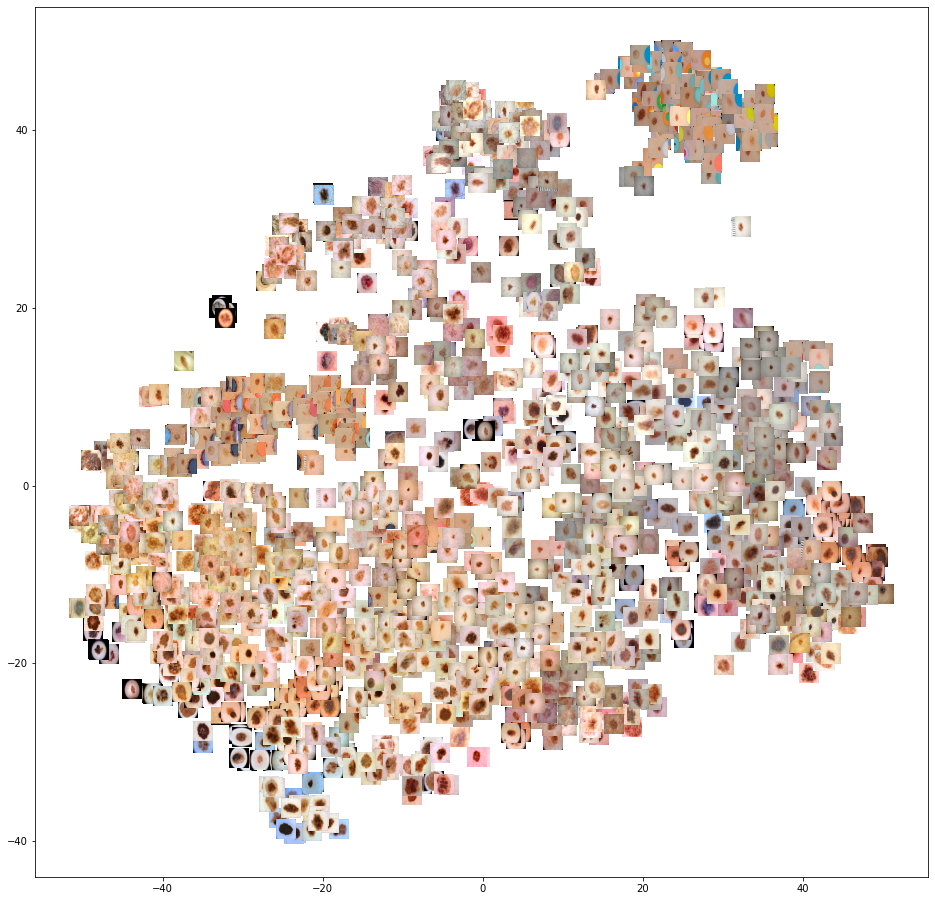

In [48]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(16, 16))
for item in range(X_embedded.shape[0]):
    ax.scatter(X_embedded[item,0], X_embedded[item,1])
    #plt.annotate(str(item),(X_embedded[item,0], X_embedded[item,1]))
    ab = AnnotationBbox(OffsetImage(resized_images[item], cmap="Greys_r"),  #resized_images[item][0]
                        (X_embedded[item,0], X_embedded[item,1]), frameon=False)
    ax.add_artist(ab)

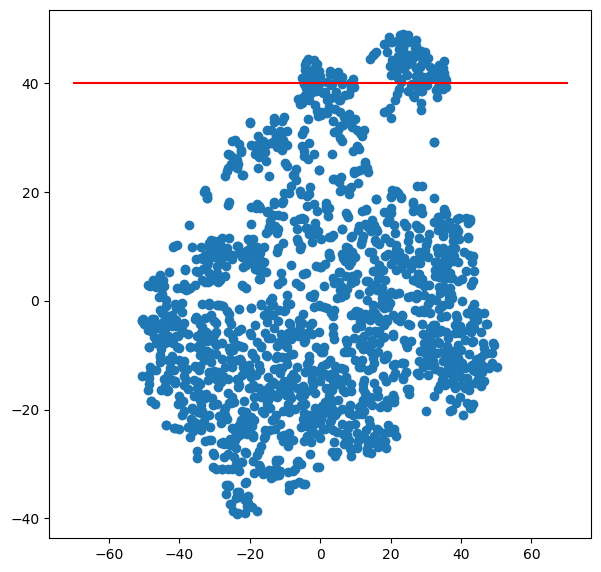

In [49]:
plt.figure(0, figsize=(7, 7), dpi=100)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
x = np.linspace(-70,70,2)
y = 0*x+40
plt.plot(x, y, '-r', label='y=2x+1');

### Plot raw data UMAP

(1627, 512)
(1627, 512)
(1627, 3)
(1627,)
[0 1 2]
(1627, 512) (1627,)


<Figure size 864x720 with 0 Axes>

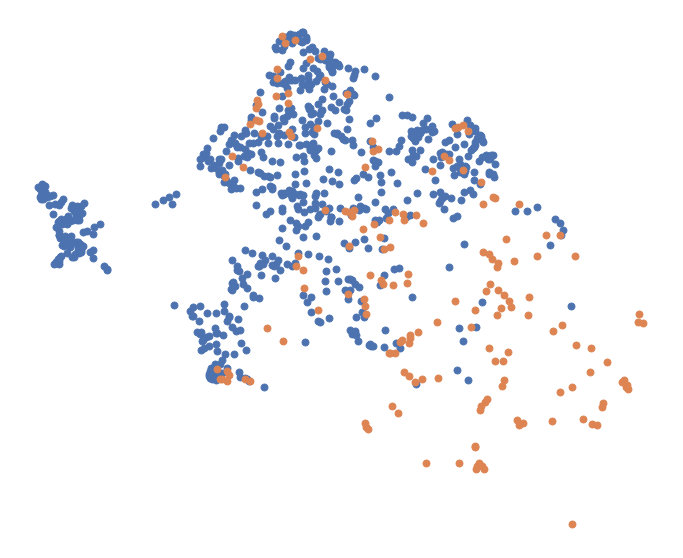

In [34]:
import umap
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)

sns.set(context="paper", style="white")

raw_train = intermediate_output #x3
raw_annot = y3


print(raw_train.shape)
raw_t_s = np.array([img.flatten() for img in raw_train])
print(raw_t_s.shape)
print(raw_annot.shape)
raw_annot_flat = np.argmax(raw_annot, axis=1)
print(raw_annot_flat.shape)

raw_annot_flat_3 = raw_annot_flat
print(np.unique(raw_annot_flat_3))
print(raw_t_s.shape, raw_annot_flat_3.shape)


data = raw_t_s

reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(data)

colour_map = raw_annot_flat_3

tsneFigure = plt.figure(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(12, 10))

for colour in range(2): # 1 - benign only, 2- malig benign, 3 - malig benign synth malig
    indices = np.where(colour_map==colour)
    indices = indices[0]
    
    if colour == 0:
        l = "Benign"
    if colour == 1:
        l = "Malignant"
    if colour == 2:
        l = "Generated Malignant"

    plt.setp(ax, xticks=[], yticks=[])
    plt.scatter(embedding[:, 0][indices],
                embedding[:, 1][indices],
                label=None, cmap="Spectral", s=50)
    

#plt.legend(loc='lower left', prop={'size': 20})
plt.axis('off')
plt.savefig("raw_UMAP.pdf", bbox_inches = 'tight', pad_inches = 0, dpi=1000)
plt.show()

(1627, 512)
(1627, 512)
(1627, 3)
(1627,)
[0 1 2]
(1627, 512) (1627,)


<Figure size 864x720 with 0 Axes>

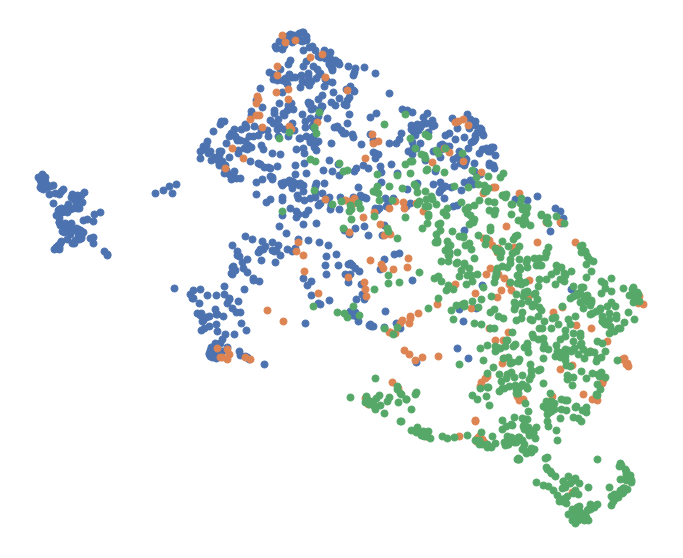

In [35]:
import umap
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)

sns.set(context="paper", style="white")

raw_train = intermediate_output #x3
raw_annot = y3


print(raw_train.shape)
raw_t_s = np.array([img.flatten() for img in raw_train])
print(raw_t_s.shape)
print(raw_annot.shape)
raw_annot_flat = np.argmax(raw_annot, axis=1)
print(raw_annot_flat.shape)

raw_annot_flat_3 = raw_annot_flat
print(np.unique(raw_annot_flat_3))
print(raw_t_s.shape, raw_annot_flat_3.shape)


data = raw_t_s

reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(data)

colour_map = raw_annot_flat_3

tsneFigure = plt.figure(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(12, 10))

for colour in range(3): # 1 - benign only, 2- malig benign, 3 - malig benign synth malig
    indices = np.where(colour_map==colour)
    indices = indices[0]
    
    if colour == 0:
        l = "Benign"
    if colour == 1:
        l = "Malignant"
    if colour == 2:
        l = "Generated Malignant"

    plt.setp(ax, xticks=[], yticks=[])
    plt.scatter(embedding[:, 0][indices],
                embedding[:, 1][indices],
                label=None, cmap="Spectral", s=50)
    

#plt.legend(loc='lower left', prop={'size': 20})
plt.axis('off')
plt.savefig("gan_UMAP.pdf", bbox_inches = 'tight', pad_inches = 0, dpi=1000)
plt.show()

### Visualized and save the oversampled dataset

In [24]:
# inital dataset + generated samples
x_new.shape, y_new.shape

((1627, 256, 256, 3), (1627, 2))

In [6]:
#max(np.array(gen).flatten()), min(np.array(gen).flatten())

In [7]:
#max(x_new.flatten()), min(x_new.flatten())

### Raw data

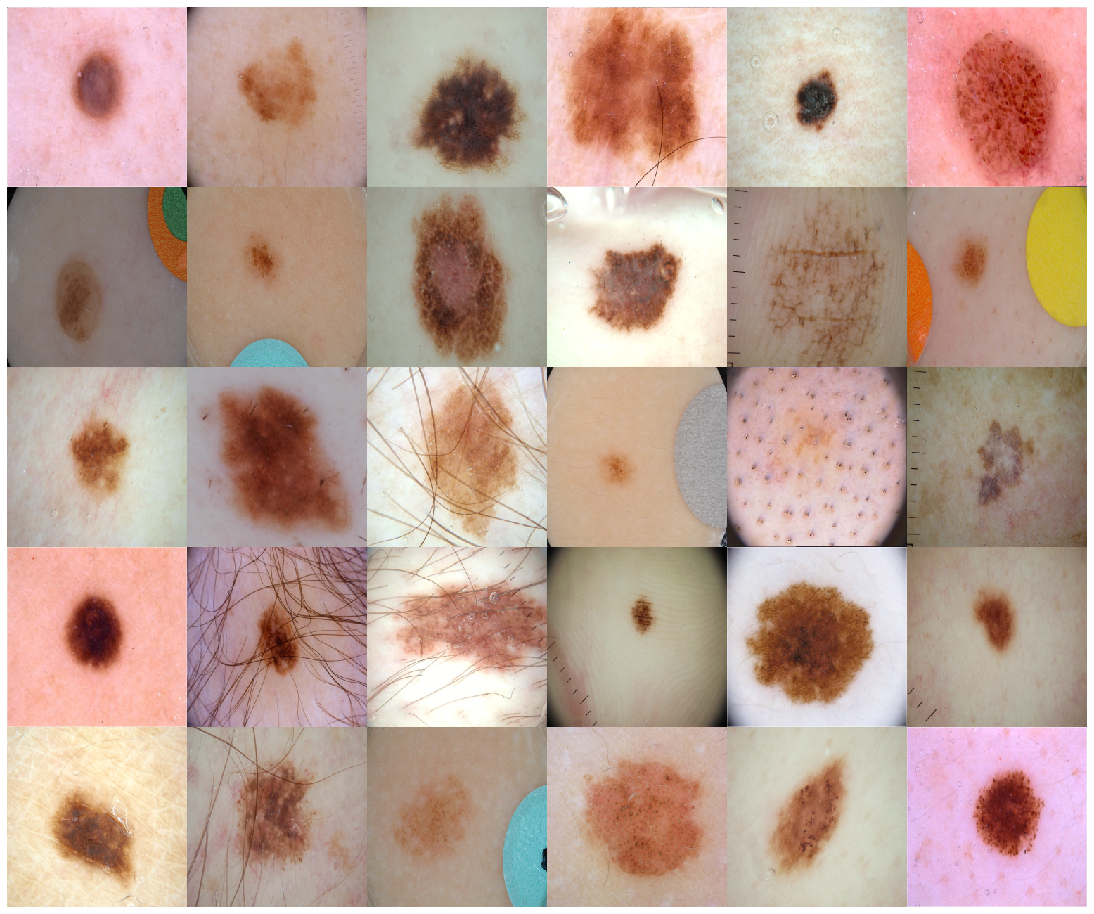

In [20]:
from numpy.random import rand
import matplotlib.pyplot as plt

index = np.random.choice(np.array(gen).shape[0], 30, replace=False)
raw = np.array(raw)
x = raw[index]

a, b = 5, 6
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}/outputs/".format(ROOT_DIR), "beforegan"), dpi=300)
plt.show()

### Synthesize data

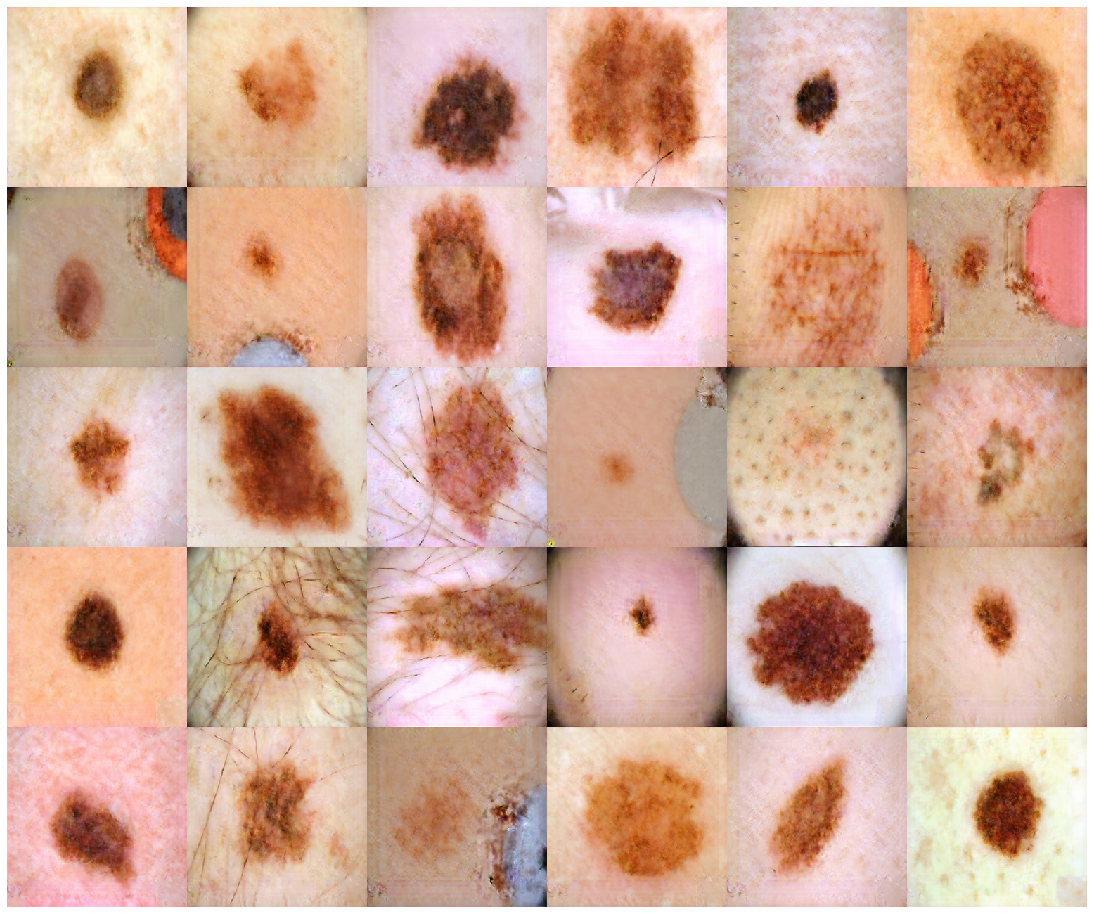

In [21]:
from numpy.random import rand
import matplotlib.pyplot as plt

gen = np.array(gen)
x = gen[index]

a, b = 5, 6
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}/outputs/".format(ROOT_DIR), "aftergan"), dpi=300)
plt.show()

In [11]:
#helpers.show_images(raw[-20:], cols = 3, titles = None, save_fig = "default")

In [12]:
#helpers.show_images(gen[-20:], cols = 3, titles = None, save_fig = "default")

In [6]:
a = np.array([np.argmax(y) for y in y_new])
len(a)

1627

In [7]:
np.unique(a)

array([0, 1])

In [8]:
np.count_nonzero(a == 0), np.count_nonzero(a == 1)
#np.count_nonzero(a == 0), np.count_nonzero(a == 1), np.count_nonzero(a == 2)

(727, 900)

In [9]:
x_new.shape, y_new.shape

((1627, 256, 256, 3), (1627, 2))

In [16]:
# Create directory
helpers.create_directory("{}/dataset/isic2016gan/".format(ROOT_DIR))


# Save
np.save("{}/dataset/isic2016gan/{}{}.npy".format(ROOT_DIR, "x_", model_name[:-3]), x_new)
np.save("{}/dataset/isic2016gan/{}{}.npy".format(ROOT_DIR, "y_", model_name[:-3]), y_new)